In [16]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the dataset (assuming it's in 'monkeypox_tweets.csv')
df = pd.read_csv('/kaggle/working/merged.csv')

# Filter for English language tweets if needed
df = df[df['language'] == 'en']

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER to get sentiment scores for each tweet
df['vader_sentiment'] = df['tweet'].apply(lambda tweet: analyzer.polarity_scores(tweet)['compound'])

# Convert sentiment scores to categorical labels
df['vader_sentiment_label'] = df['vader_sentiment'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

# Display sentiment results
print(df[['tweet', 'vader_sentiment', 'vader_sentiment_label']])


/tmp/ipykernel_30/3828540240.py:5: DtypeWarning: Columns (0,1,2,4,5,10,13,14,15,16,17,18,19,20,21,22,23,25,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/working/merged.csv')


                                                    tweet  vader_sentiment  \
0       @larryd5674 @John_Kass @chicagosmayor @SAKimFo...           0.4404   
1       Monkeypox: An explainer and research roundup  ...           0.0000   
2       About Monkeypox and HOCl makers….I’m learning ...           0.4019   
4       Many like to see the U.S. as one of the most a...          -0.0018   
5       🚨🚨LA County sex workers: Monkey pox vaccines a...           0.0000   
...                                                   ...              ...   
171098  Lying that I have monkeypox so people beleive ...          -0.5267   
171099  KingBee Interview, Monkeypox , This Or That, &...           0.2500   
171100  @JLeiper @OttawaHealth That’s the place for mo...           0.0000   
171101  (SACRAMENTO)A UC Davis Health study finds that...           0.7184   
171102  “I’ve not heard of one action directly aimed a...           0.2960   

       vader_sentiment_label  
0                   positive  
1

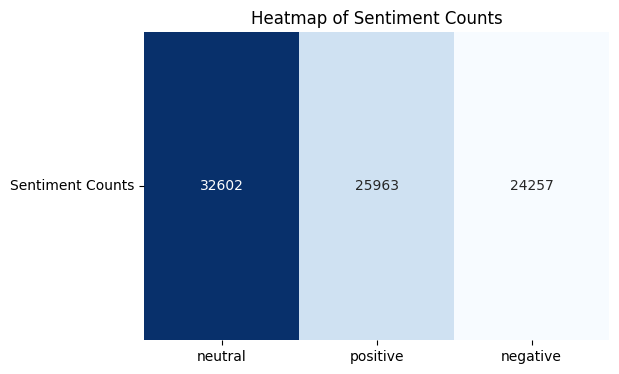

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment category
sentiment_counts = df['vader_sentiment_label'].value_counts().to_frame()

# Convert index into a column for easy plotting
sentiment_counts.reset_index(inplace=True)
sentiment_counts.columns = ['Sentiment', 'Count']

# Plot heatmap (but this will be more like a heatmap-style barplot)
plt.figure(figsize=(6, 4))
sns.heatmap(sentiment_counts[['Count']].T, annot=sentiment_counts[['Count']].T, cmap='Blues', cbar=False, fmt='d')
plt.yticks([0.5], ['Sentiment Counts'], rotation=0)
plt.xticks(ticks=[i+0.5 for i in range(len(sentiment_counts))], labels=sentiment_counts['Sentiment'])

plt.title('Heatmap of Sentiment Counts')
plt.show()


In [5]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.3 MB/s eta 0:00:00


In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential

# Tokenize and preprocess the tweets
max_features = 10000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['tweet'])
sequences = tokenizer.texts_to_sequences(df['tweet'])
padded_sequences = pad_sequences(sequences, maxlen=100)

# Assuming sentiment labels are created (you can use VADER results)
df['sentiment_label'] = df['vader_sentiment_label'].apply(lambda x: 1 if x == 'positive' else (0 if x == 'neutral' else -1))

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['sentiment_label'], test_size=0.2)

# Define BiLSTM model
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

# Compile and train the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")


Epoch 1/5
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.4182 - loss: -4.4287 - val_accuracy: 0.4370 - val_loss: -22.2311
Epoch 2/5
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.4578 - loss: -34.3877 - val_accuracy: 0.4358 - val_loss: -54.3870
Epoch 3/5
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.4838 - loss: -69.0203 - val_accuracy: 0.4941 - val_loss: -99.9786
Epoch 4/5
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.4960 - loss: -123.8218 - val_accuracy: 0.4882 - val_loss: -150.1174
Epoch 5/5
2071/2071 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.5278 - loss: -179.1410 - val_accuracy: 0.5066 - val_loss: -201.4306
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5049 - loss: -198.0529
Test Accuracy: 0.5066103339195251


In [11]:
import pandas as pd
import gensim
from gensim import corpora
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure you have the required NLTK stopwords package
nltk.download('stopwords')
nltk.download('punkt')

# Load your dataset (assuming it's already merged)
df = pd.read_csv('/kaggle/working/merged.csv')

# Filter only English tweets if needed
df = df[df['language'] == 'en']

# Preprocessing function to clean and tokenize tweets
stop_words = set(stopwords.words('english'))
def preprocess(text):
    # Tokenize and remove stop words
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha() and word not in stop_words]

# Apply preprocessing to the tweet column
df['processed_tweet'] = df['tweet'].apply(preprocess)

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(df['processed_tweet'])
corpus = [dictionary.doc2bow(text) for text in df['processed_tweet']]

# Apply LDA model
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Print the topics found by LDA
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/tmp/ipykernel_30/2315852135.py:13: DtypeWarning: Columns (0,1,2,4,5,10,13,14,15,16,17,18,19,20,21,22,23,25,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/working/merged.csv')


(0, '0.131*"monkey" + 0.129*"pox" + 0.036*"monkeypox" + 0.021*"got" + 0.014*"jackposobiec"')
(1, '0.115*"https" + 0.100*"monkeypox" + 0.020*"cases" + 0.020*"vaccine" + 0.018*"health"')
(2, '0.066*"monkeypox" + 0.014*"people" + 0.011*"get" + 0.011*"covid" + 0.010*"gay"')
(3, '0.024*"monkeypox" + 0.014*"school" + 0.013*"amp" + 0.009*"covid" + 0.006*"ever"')
(4, '0.069*"monkeypox" + 0.049*"https" + 0.032*"hiv" + 0.027*"man" + 0.026*"first"')


In [12]:
!pip install transformers

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [19]:
import pandas as pd
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Load the merged dataset
# Filter for English tweets
df = df[df['language'] == 'en']

# Assuming you have labeled the data with 'positive', 'neutral', 'negative' (if not, VADER results can be used for labels)
# If you have no labels, you can use VADER sentiment or similar to generate labels first
# Example: df['true_sentiment'] could be ['positive', 'neutral', 'negative']
# You can replace this with your sentiment labels

# Encoding the labels
label_encoder = LabelEncoder()
df2 = df
df2['label'] = label_encoder.fit_transform(df['vader_sentiment_label'])



X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['label'], test_size=0.2, random_state=42)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Tokenize the input tweets
def encode_tweets(tweets):
    return tokenizer(
        tweets.tolist(), 
        padding=True, 
        truncation=True, 
        max_length=128, 
        return_tensors='tf'
    )

X_train_encoded = encode_tweets(X_train)
X_test_encoded = encode_tweets(X_test)

# Convert labels to tensors
y_train_encoded = tf.convert_to_tensor(y_train.values)
y_test_encoded = tf.convert_to_tensor(y_test.values)

# Use TensorFlow's optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

# Compile the model
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

# Train the model
model.fit(
    X_train_encoded['input_ids'], 
    y_train_encoded, 
    epochs=3, 
    batch_size=16, 
    validation_data=(X_test_encoded['input_ids'], y_test_encoded)
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_encoded['input_ids'], y_test_encoded)
print(f"Test Accuracy: {accuracy}")

# Make predictions
predictions = model.predict(X_test_encoded['input_ids']).logits
predictions_labels = tf.argmax(predictions, axis=1)

# Convert numeric predictions back to sentiment labels
predicted_labels = label_encoder.inverse_transform(predictions_labels.numpy())

# Generate a classification report
print(classification_report(y_test, predicted_labels, target_names=label_encoder.classes_))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x7c231b4b84c0>